# Assignment 3

# Part 1 - Improving the 5-point stencil in CUDA

In this part we are going to improve upon the cuda implementation of the evaluate discrete laplace function from assignment 2.

In [1]:
# Imports all the needed built in libraries
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt 

For the cpu and previous gpu versions I added an extra function to each that allows me to construct arrays that will have them be the same dimensions so a relative error can be calculated.  

## Cpu Version

In [2]:
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  0
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

def eval_cpu(x, N):
    '''Evalutes the CPU implementation to reshape result'''
    N = N + 2
    A, _ = discretise_poisson(N)
    x = add_zeros(x)
    res = A @ x

    res = res.reshape((N, N))
    res_fixed = []
    for i in range(N):
        row = []
        for j in range(N):
            if i == 0 or i == (N - 1) or j == 0 or j == (N - 1):
                continue
            else:
                row.append(res[i][j])
        if row:
            res_fixed.append(row)

    return res_fixed

## Previous Cuda Version

In [3]:
@cuda.jit
def evaluate_discrete_laplace(vec_in, vec_out, N, omega):
    """Evaluate the discrete Laplace operator."""
    
    i, j = cuda.grid(2)
    
    if i >= N:
        return
    if j >= N:
        return
    
    # Compute the vector index
    k = j * (N) + i
    
    if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        # We are at the boundary
        # Here, the matrix just acts like the identity
        vec_out[k] = 0
        return
    
    # Now deal with the interior element
    
    up = vec_in[(j + 1) * N + i]
    down = vec_in[(j - 1) * N + i]
    left = vec_in[j * N + i - 1]
    right = vec_in[j * N + i + 1]
    center = vec_in[k]
    
    vec_out[k] = (N - 1)**2 * (numba.float32(4) * center - up - down - left - right)+(center * (omega**2))
    
def eval_gpu(x, N, omega):
    '''runs steps required to evalute result from evaluate_discrete_laplace'''
    N = N + 2
    nblocks = (N + (SX - 1)) // SX
    res = np.zeros(N * N, dtype=np.float32)
    
    evaluate_discrete_laplace[(nblocks, nblocks), (SX, SY)](x.astype('float32'), res, N, omega)
    
    return res

## Making 3 Changes (GPU V2)

In [4]:
# Define the size of the ThreadBlock
SX = 32
SY = 32

# Shared array shape
SAS = (SX+2, SY+2)

@cuda.jit
def evaluate_discrete_laplace_v2(vec_in, vec_out, N, omega):
    """Evaluate the discrete Laplace operator."""
    
    # Creat shared memory
    local_arr = cuda.shared.array((SAS), numba.float32)

    # Local coordinates
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    # Global coordinates
    i, j = cuda.grid(2)

    # i and j need to be within boundaries
    if i >= N:
        return
    if j >= N:
        return

    # define global index pointer for vec_in
    k = j * N + i

    # define local index pointer for shared_array
    say = ty + 1
    sax = tx + 1

    # load elements of vec_in to shared memory
    local_arr[say, sax] = vec_in[k]

    
    # TOP ROW
    
    # Top row of gridblock
    if ty == 0:
        local_arr[say - 1, sax] = vec_in[k - N]
    # Top row of grid   
    if j == 0:
        local_arr[say - 1, sax] = numba.float32(0)
    
    # BOTTOM ROW
    
    # Bottom row of gridblock
    if ty == (SY - 1):
        local_arr[say + 1, sax] = vec_in[k + N]
     # Bottom row of grid  
    if j == (N - 1):
        local_arr[say + 1, sax] = numba.float32(0)
    
    # LEFT MOST COLUMN
    
    # Left most column of gridblock
    if tx == 0:
        local_arr[say, sax - 1] = vec_in[k - 1]
    # Left most column of grid  
    if i == 0:
        local_arr[say, sax - 1] = numba.float32(0)
    
    # RIGHT MOST COLUMN
    
    # Right most column of gridblock
    if tx == (SX - 1):
        local_arr[say, sax + 1] = vec_in[k + 1]
    # Right most column of grid    
    if i == (N - 1):
        local_arr[say, sax + 1] = numba.float32(0)


    cuda.syncthreads()

    # calculate 5 stencil points
    up = local_arr[say - 1, sax]
    down = local_arr[say + 1, sax]
    left = local_arr[say, sax - 1]
    right = local_arr[say, sax + 1]
    center = local_arr[say, sax]

    # transfer calculated stencil back to global vec_out
    vec_out[k] = ((N + 2) - 1)**2 * (numba.float32(4) * center - up - down - left - right) + ((omega**2)*center)
    
def eval_gpu_v2(x, N, omega):
    """Evaluate the discrete Laplacian on the GPU."""
    
    res =  np.zeros(N*N, dtype=np.float32)
    
    nblocks = (N + 31) // 32
    evaluate_discrete_laplace_v2[(nblocks, nblocks), (32, 32)](x.astype('float32'), res, N, omega)
    return res

Changed the 5-point stencil to incorporate local memory by using threadblocks. The code works by first defining all the local variables using the threadblock size. The reason I have used SX+2 is because we want our shared memory to read in a larger neighbourhood than SX as we have to check around elements and need to account for the elements at the boundary. The local coordinates for each thread and the global coordinates are then defined, which are used to populate local_arr. The position of each element (vector index) is then used to define the boundary of the grid local_arr and the boundaries of each threadblock by the movement of memory. This is done by considering the top, bottom rows and left most and right most columns. We then implement the 5-point stencil method to the interior elements and save them to local_arr which will then have its elements transferred to vec_out. I then implemented omega and demonstrated it below.

In [5]:
# Allows us to make result from evaluate_discrete_laplace the correct dimension
def add_zeros(x):
    '''function to add zeros at the boundary for the original cuda implementation'''
    x = x.reshape((N, N))
    new_x = np.zeros((N + 2, N + 2))
    
    for i in range(N):
        for j in range(N):
            new_x[i + 1][j + 1] = x[i][j]
    return new_x.ravel()

In [6]:
# Sets constants
N = 500
omega = 0
rand = np.random.RandomState(0)
x = rand.randn(N * N)

In [7]:
# CPU implementation 
y_cpu = eval_cpu(x, N)

In [8]:
# Calculate result based on evaluate_discrete_laplace
x_gpu = add_zeros(x)
y_gpu = eval_gpu(x_gpu, N, omega)

# Reshape old gpu by removing zeros

y_gpu = y_gpu.reshape((N + 2, N + 2))
y_gpu_new = []

for i in range(N + 2):
    row = []
    for j in range(N + 2):
        if i == 0 or i == (N + 2 - 1) or j == 0 or j == (N + 2 - 1):
            continue
        else:
            row.append(y_gpu[i][j])
    if row:
        y_gpu_new.append(row)

y_gpu = y_gpu_new

In [9]:
# Sets new dimensions for latest gpu version
imp_gpu = eval_gpu_v2(x,N,omega)
imp_gpu = imp_gpu.reshape(N, N)

In [10]:
# Calculate residual between gpu v2 and gpu v1

rel_error = np.linalg.norm(y_gpu - imp_gpu, np.inf) / np.linalg.norm(y_gpu, np.inf)
print(f"Relative error between gpu v2 and gpu v1: \n{rel_error}.")

# Calculate residual between gpu v2 and cpu

rel_error = np.linalg.norm(y_cpu - imp_gpu, np.inf) / np.linalg.norm(y_cpu, np.inf)
print(f"Relative error between cpu and gpu v2: \n{rel_error}.")

Relative error between gpu v2 and gpu v1: 
2.359691286812904e-08.
Relative error between cpu and gpu v2: 
5.419254196525032e-08.


As the relative error of our new gpu implementation in comparison to the cpu and original gpu implementation is very small it shows that our values are very similar and that our v2 is functional. 

## Benchmark

In [11]:
%timeit eval_gpu_v2(x, N, omega)

3.54 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit eval_gpu(x, N, omega)

3.15 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Version 2 of the gpu implementation has a slightly quicker run time than the old version and consistently has a smaller uncertainty making it a more reliable option with a consistent run time.

# Part 2: Solving modifed Helmholtz problems with CG on the GPU

In this part of the assignment, we want to use the CG solver to solve PDEs on the GPU.

In [13]:
# Import needed libraries

from scipy.sparse import diags
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import LinearOperator

## Cpu implementation

CPU implementation that solves Ax = b systems, taken from the notes.

In [14]:
# Creating a symetric positive matrix

n = 10000
data = [2.1 * np.ones(n),
        -1. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

offsets = [0, 1, -1]

A = diags(data, offsets=offsets, shape=(n, n), format='csr')
print(A)

  (0, 0)	2.1
  (0, 1)	-1.0
  (1, 1)	2.1
  (1, 2)	-1.0
  (1, 0)	-1.0
  (2, 2)	2.1
  (2, 3)	-1.0
  (2, 1)	-1.0
  (3, 3)	2.1
  (3, 4)	-1.0
  (3, 2)	-1.0
  (4, 4)	2.1
  (4, 5)	-1.0
  (4, 3)	-1.0
  (5, 5)	2.1
  (5, 6)	-1.0
  (5, 4)	-1.0
  (6, 6)	2.1
  (6, 7)	-1.0
  (6, 5)	-1.0
  (7, 7)	2.1
  (7, 8)	-1.0
  (7, 6)	-1.0
  (8, 8)	2.1
  (8, 9)	-1.0
  :	:
  (9991, 9992)	-1.0
  (9991, 9990)	-1.0
  (9992, 9992)	2.1
  (9992, 9993)	-1.0
  (9992, 9991)	-1.0
  (9993, 9993)	2.1
  (9993, 9994)	-1.0
  (9993, 9992)	-1.0
  (9994, 9994)	2.1
  (9994, 9995)	-1.0
  (9994, 9993)	-1.0
  (9995, 9995)	2.1
  (9995, 9996)	-1.0
  (9995, 9994)	-1.0
  (9996, 9996)	2.1
  (9996, 9997)	-1.0
  (9996, 9995)	-1.0
  (9997, 9997)	2.1
  (9997, 9998)	-1.0
  (9997, 9996)	-1.0
  (9998, 9998)	2.1
  (9998, 9999)	-1.0
  (9998, 9997)	-1.0
  (9999, 9999)	2.1
  (9999, 9998)	-1.0


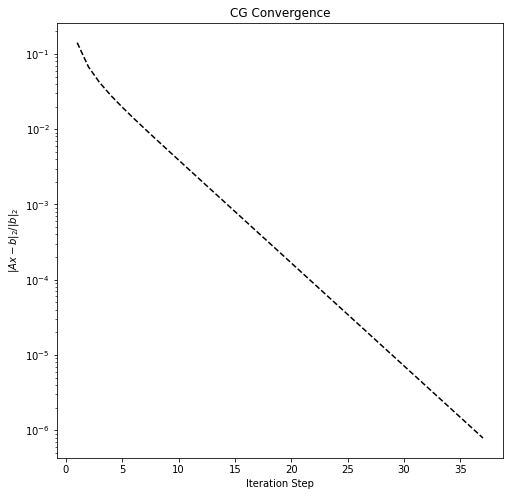

In [15]:
# Solving the associated linear system with CG 

b = np.ones(n)
residuals = []
callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
sol, _ = cg(A, b, tol=1E-6, callback=callback, maxiter=1000)

# Convergence

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(1 + np.arange(len(residuals)), residuals, 'k--')
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-b\|_2 / \|b\|_2$')

## GPU implementation

In [16]:
# Define a function for the linear operator
def new_eval_gpu_cg(x):
    """Evaluate the discrete Laplacian on the GPU."""
    res = np.empty(N*N, dtype=np.float32)
    nblocks = (N + SX - 1) // 32
    evaluate_discrete_laplace[(nblocks, nblocks), (32, 32)](x.astype('float32'), res, N, omega)
    return res.astype('float64')